<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/Autoencoder_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here's a complete guide and code to help you train an autoencoder on 100 normal ECG signals and detect anomalies from heart patient ECG data. We'll use:

MIT-BIH Normal Sinus Rhythm dataset for training (normal ECGs)

MIT-BIH Arrhythmia dataset for testing (abnormal ECGs)

An autoencoder model in Keras

Visualization of reconstructions and anomaly detection

🔧 Step-by-Step Plan
1. Dataset
Normal ECG: Use records from the MIT-BIH Normal Sinus Rhythm Database (100 ECGs)

Abnormal ECG: Use records from the MIT-BIH Arrhythmia Database

2. Preprocessing
Resample signals

Normalize

Segment into fixed-size windows (e.g., 256 samples)

3. Autoencoder
Train only on normal ECG windows

Detect anomaly by reconstruction error

4. Evaluation
Visualize normal vs abnormal ECG reconstruction

Plot reconstruction error

✅ Installation (Google Colab)

In [1]:
!pip install wfdb scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


📁 1. Load ECG Data

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

def load_ecg(record_name, path='mitdb', segment_length=256):
    record = wfdb.rdrecord(os.path.join(path, record_name))
    ecg = record.p_signal[:, 0]  # Lead I or Lead II typically
    # Normalize and segment
    scaler = MinMaxScaler()
    ecg = scaler.fit_transform(ecg.reshape(-1, 1)).flatten()
    segments = []
    for i in range(0, len(ecg) - segment_length, segment_length):
        segments.append(ecg[i:i+segment_length])
    return np.array(segments)


📥 2. Download MIT-BIH Normal & Abnormal ECGs

In [5]:
import wfdb

# Download Normal ECGs (e.g., 16265, 16272, 16273... from NSRDB)
normal_ids = ['16265', '16272', '16273']
for rid in normal_ids:
    wfdb.dl_database('nsrdb', dl_dir='nsrdb', records=[rid])

# Download 1 abnormal ECG (e.g., 100 from MIT-BIH Arrhythmia)
wfdb.dl_database('mitdb', dl_dir='mitdb', records=['100'])

Generating record list for: 16265
Generating list of all files for: 16265
Finished downloading files
Generating record list for: 16272
Generating list of all files for: 16272
Finished downloading files
Generating record list for: 16273
Generating list of all files for: 16273
Finished downloading files
Generating record list for: 100
Generating list of all files for: 100
Created local base download directory: mitdb
Finished downloading files


🧹 3. Prepare Training Data (Normal Only)

In [6]:
X_train = []
for rid in normal_ids:
    segments = load_ecg(rid, path='nsrdb')
    X_train.append(segments)
X_train = np.vstack(X_train)

print("Training ECG shape:", X_train.shape)  # (num_segments, 256)


Training ECG shape: (135173, 256)


🤖 4. Autoencoder Model (Keras)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_train.shape[1]

# Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,688 (338.62 KB)

 Trainable params: 86,688 (338.62 KB)

 Non-trainable params: 0 (0.00 B)

🏋️ 5. Train Autoencoder

In [8]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 2/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 4/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 6/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 7/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 8/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 10/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/30
3380/3380 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/30
3380/338

📊 6. Visualize Loss Curve

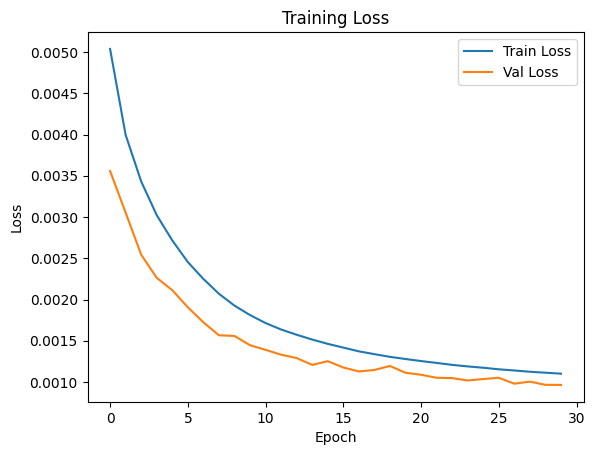

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


🔎 7. Test on Abnormal ECG (from Patient)

In [10]:
X_test = load_ecg('100', path='mitdb')
X_pred = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - X_pred, 2), axis=1)
threshold = np.max(np.mean(np.power(X_train - autoencoder.predict(X_train), 2), axis=1))

print("Anomaly Threshold (based on training set):", threshold)

# Flag anomalies
anomalies = mse > threshold
print("Detected anomalies:", np.sum(anomalies), "/", len(X_test))


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4225/4225 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Anomaly Threshold (based on training set): 0.06622620373711233
Detected anomalies: 0 / 2539


📈 8. Visualization of Normal vs Anomalous

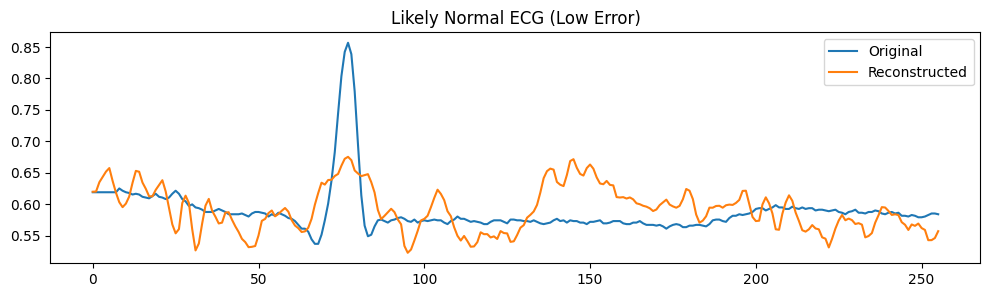

In [11]:
def plot_ecg(original, reconstructed, title):
    plt.figure(figsize=(12, 3))
    plt.plot(original, label='Original')
    plt.plot(reconstructed, label='Reconstructed')
    plt.title(title)
    plt.legend()
    plt.show()

# Normal example
plot_ecg(X_test[0], X_pred[0], "Likely Normal ECG (Low Error)")

# Anomaly example
for i in range(len(anomalies)):
    if anomalies[i]:
        plot_ecg(X_test[i], X_pred[i], "Anomalous ECG (High Error)")
        break
